<a href="https://colab.research.google.com/github/ysooch0819/AI16-Projects/blob/main/ai16_section1_project_%EC%9C%A4%EC%88%98%EC%B0%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math


In [2]:
# AIB 16기 윤수창 - Section 1 Project
# 다음 분기에 어떤 게임을 설계해야 할까?

# Name : 게임의 이름입니다.
# Platform : 게임이 지원되는 플랫폼의 이름입니다.
# Year : 게임이 출시된 연도입니다.
# Genre : 게임의 장르입니다.
# Publisher : 게임을 배급한 회사입니다.
# NA_Sales : 북미지역에서의 출고량입니다.
# EU_Sales : 유럽지역에서의 출고량입니다.
# JP_Sales : 일본지역에서의 출고량입니다.
# Other_Sales : 기타지역에서의 출고량입니다.

import pandas as pd

df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv', index_col=0)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB


In [3]:
# 키워드 정리
# Sprint 1 : EDA, Feature Engineering, Data Manipulation, Data Visualization
# Sprint 2 : Hypothesis Test, CI, Bayesian, AB Test
# Sprint 3 : DR, PCA, Clustering, GD

# 반드시 들어가야하는 내용 요약
# '지역에 따라서 선호하는 게임 장르가 다를까?' 라는 질문에 대답을 하셔야합니다.   Genre 와 NA_Sales, EU_Sales, JP_Sales, Other_Sales
# '연도별 게임의 트렌드가 있을까?' 라는 질문에 대답을 하셔야합니다.               Year 와 Genre, Platform
# '출고량이 높은 게임'에 대한 분석 및 시각화 프로세스가 포함되어야 합니다.        Sales 총합과 Platform, Year, Genre, Publisher


In [4]:
# EDA
# 결측치 체크
missing_values = df[(df.Year.isnull()== True) | (df.Genre.isnull()==True) | (df.Publisher.isnull()== True) | (df.NA_Sales.isnull() == True) | (df.EU_Sales.isnull() == True) | (df.JP_Sales.isnull() == True) | (df.Other_Sales.isnull() == True) ]
print(round(missing_values.shape[0] / df.shape[0], 3))
# 전체 데이터 개수 중 nan 값이 차지하는 비율 = 0.022, pvalue는 아니지만 0.05 보다 작으니까 과감히 dropna 해준다. NaN 값이 있으면 행을 삭제 후 인덱스 재정렬

df1 = df.dropna(axis=0)

# 중복치 체크 0 없다.
df1.duplicated().sum()

0.022


0

In [5]:
# Year는 int형, 각종 Sales는 단위 통일해준다.
# Year부터 처리

# 0 이상 20 미만의 값은 2000을 더해주고, 80이상 100 미만의 값은 1900을 더해준다.
df1.Year = df1.Year.astype('int')
df1.loc[df1.Year < 20, 'Year'] = df1.loc[df1.Year < 20, 'Year'] + 2000
df1.loc[(df1.Year >= 80) & (df1.Year < 100), 'Year'] = df1.loc[(df1.Year >= 80) & (df1.Year < 100), 'Year'] + 1900

print(df1[(df1.Year < 100)].shape[0])


0


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [6]:
# Sales 단위에 통일이 필요하다.
# 숫자가 아닌 문자가 들어있는 행 출력 
df_copy = df1.copy()
# 0M 또는 0K 는 그냥 0으로
# 소수점 데이터(단위 M으로 맞춰져있는)들을 기준으로 잡고, M은 M을 지워주면 끝
# K는 소수점을 붙여줘야한다.

df_copy['NA_Sales'][df_copy['NA_Sales'].str[-1] == 'K'] = df_copy['NA_Sales'][df_copy['NA_Sales'].str[-1] == 'K'].str.replace('K','').astype('float') /1000
df_copy['NA_Sales'][df_copy['NA_Sales'].str[-1] == 'M'] = df_copy['NA_Sales'][df_copy['NA_Sales'].str[-1] == 'M'].str.replace('M','').astype('float')

df_copy['EU_Sales'][df_copy['EU_Sales'].str[-1] == 'K'] = df_copy['EU_Sales'][df_copy['EU_Sales'].str[-1] == 'K'].str.replace('K','').astype('float') /1000
df_copy['EU_Sales'][df_copy['EU_Sales'].str[-1] == 'M'] = df_copy['EU_Sales'][df_copy['EU_Sales'].str[-1] == 'M'].str.replace('M','').astype('float')

df_copy['JP_Sales'][df_copy['JP_Sales'].str[-1] == 'K'] = df_copy['JP_Sales'][df_copy['JP_Sales'].str[-1] == 'K'].str.replace('K','').astype('float') /1000
df_copy['JP_Sales'][df_copy['JP_Sales'].str[-1] == 'M'] = df_copy['JP_Sales'][df_copy['JP_Sales'].str[-1] == 'M'].str.replace('M','').astype('float')

df_copy['Other_Sales'][df_copy['Other_Sales'].str[-1] == 'K'] = df_copy['Other_Sales'][df_copy['Other_Sales'].str[-1] == 'K'].str.replace('K','').astype('float') /1000
df_copy['Other_Sales'][df_copy['Other_Sales'].str[-1] == 'M'] = df_copy['Other_Sales'][df_copy['Other_Sales'].str[-1] == 'M'].str.replace('M','').astype('float')

# df_copy['NA_Sales'].astype('float')





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7

In [7]:
# 올바르게 정제된 값을 다시 사용할 데이터프레임에 넣어준다.
df1 = df_copy

# 각 Sales 컬럼의 값은 numerical 하게 바꾸어 준다.
df1['NA_Sales'] = pd.to_numeric(df1['NA_Sales'])
df1['EU_Sales'] = pd.to_numeric(df1['EU_Sales'])
df1['JP_Sales'] = pd.to_numeric(df1['JP_Sales'])
df1['Other_Sales'] = pd.to_numeric(df1['Other_Sales'])

df1.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 16241 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16241 non-null  object 
 1   Platform     16241 non-null  object 
 2   Year         16241 non-null  int64  
 3   Genre        16241 non-null  object 
 4   Publisher    16241 non-null  object 
 5   NA_Sales     16241 non-null  float64
 6   EU_Sales     16241 non-null  float64
 7   JP_Sales     16241 non-null  float64
 8   Other_Sales  16241 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.7+ MB


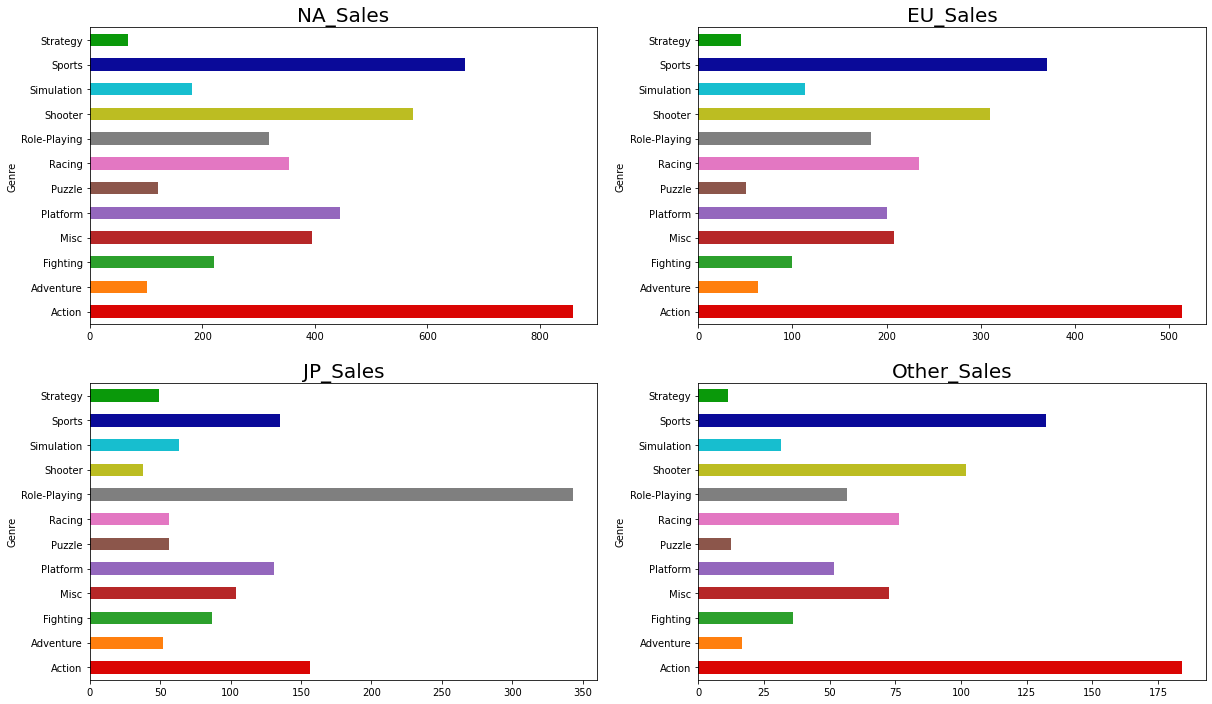

In [8]:
# '지역에 따라서 선호하는 게임 장르가 다를까?' 라는 질문에 대답을 하셔야합니다.   Genre 와 NA_Sales, EU_Sales, JP_Sales, Other_Sales
# 지역별로 Genre 별 출고량의 비율을 비교한다.
# 귀무가설 H0 : '지역에 따라서 선호하는 게임 장르는 차이가 없다'
# 대립가설 Ha : '지역에 따라서 선호하는 게임 장르가 다르다'

# 장르별로 지역별 출고 합계
df_locgen = df1.groupby('Genre')[['NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales']].sum()
# print(df_locgen)
# 지역별 장르의 출고수를 시각화해보자
locgen_na = df_locgen.NA_Sales
locgen_eu = df_locgen.EU_Sales
locgen_jp = df_locgen.JP_Sales
locgen_other = df_locgen.Other_Sales

# 12개 임의의 색상 지정
colors=['#da0503', '#ff7f0e', '#2ca02c', '#b62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#0a0a99', '#0a990a']

plt.figure(figsize=(20,12))
# 2*2 행렬 형태로 지역별 출고수 그래프 출력
plt.subplot(2, 2, 1)
locgen_na.plot.barh(x='Genre', color= colors)
plt.title('NA_Sales', fontsize=20)


plt.subplot(2, 2, 2)
locgen_eu.plot.barh(x='Genre',color= colors)
plt.title('EU_Sales', fontsize=20)


plt.subplot(2, 2, 3)
locgen_jp.plot.barh(x='Genre', color= colors)
plt.title('JP_Sales', fontsize=20)


plt.subplot(2, 2, 4)
locgen_other.plot.barh(x='Genre', color= colors)
plt.title('Other_Sales', fontsize=20)
plt.show();
# 시각화해서 살펴보면, NA, EU, 기타 시장에서는 장르 선호도가 비슷하나, 일본 시장에서는 확연히 다른 선호도를 보여준다. 이는 귀무가설을 기각할 근거가 될 수 있다.

# 북미/EU/기타 국가들에서의 장르 선호도 순서는 액션 > 스포츠 > 슈팅게임이 강세를 보여왔고, 일본에서는 유독 액션보다 롤플레잉 장르가 인기 있어왔다.
# 국내 게임시장은 일본 시장을 따라가는 경우가 많으므로, 가챠 시스템이 포함된 모바일형 MMORPG를 만드는 것이 좋겠다. 

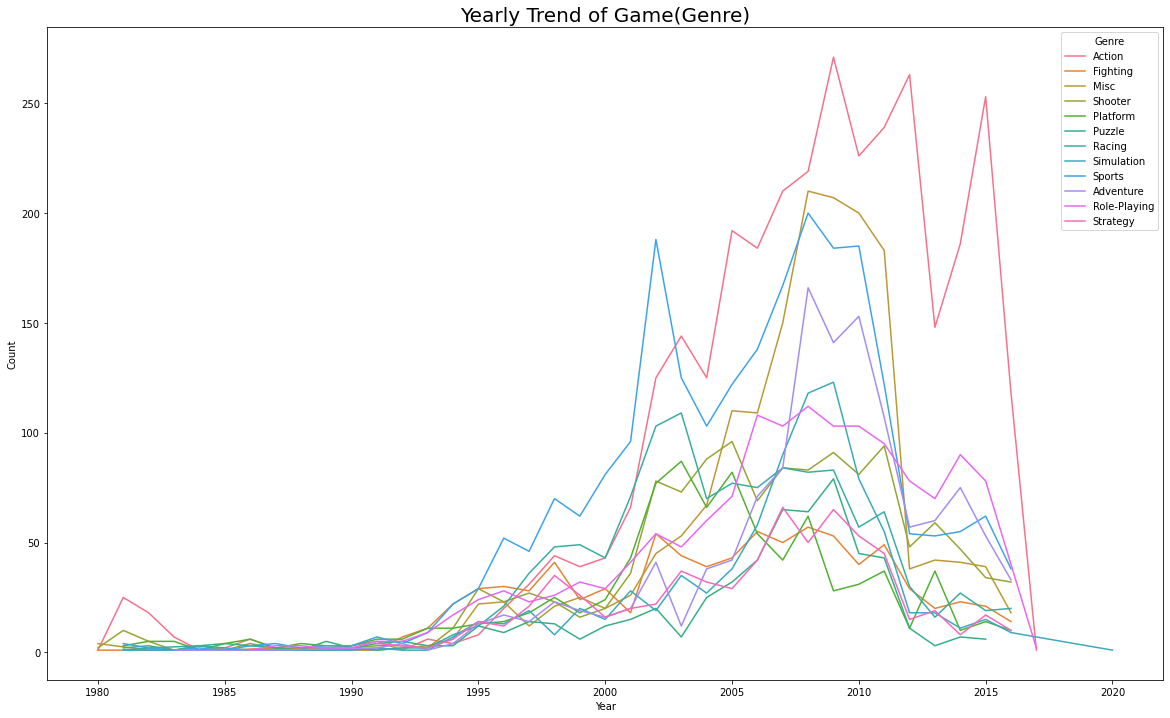

In [9]:
# '연도별 게임의 트렌드가 있을까?' 라는 질문에 대답을 하셔야합니다.               Year 와 Genre, Platform

# 연도별 게임 트렌드를 시각화 해본다.
# 연도별 장르의 변화를 살펴본다.
df_year_genre = df1.groupby(['Year', 'Genre']).size().reset_index(name='Count')

plt.figure(figsize=(20,12))
plt.title('Yearly Trend of Game(Genre)', fontsize=20)
sns.lineplot(data=df_year_genre, x= 'Year', y= 'Count', hue='Genre');
plt.show();
# year_max_sales = df1.groupby(['Year', 'Genre'])['Total_Sales'].sum().reset_index()
# year_max_sales

# ax = sns.lineplot(data = df_year_genre,  hue='Genre')


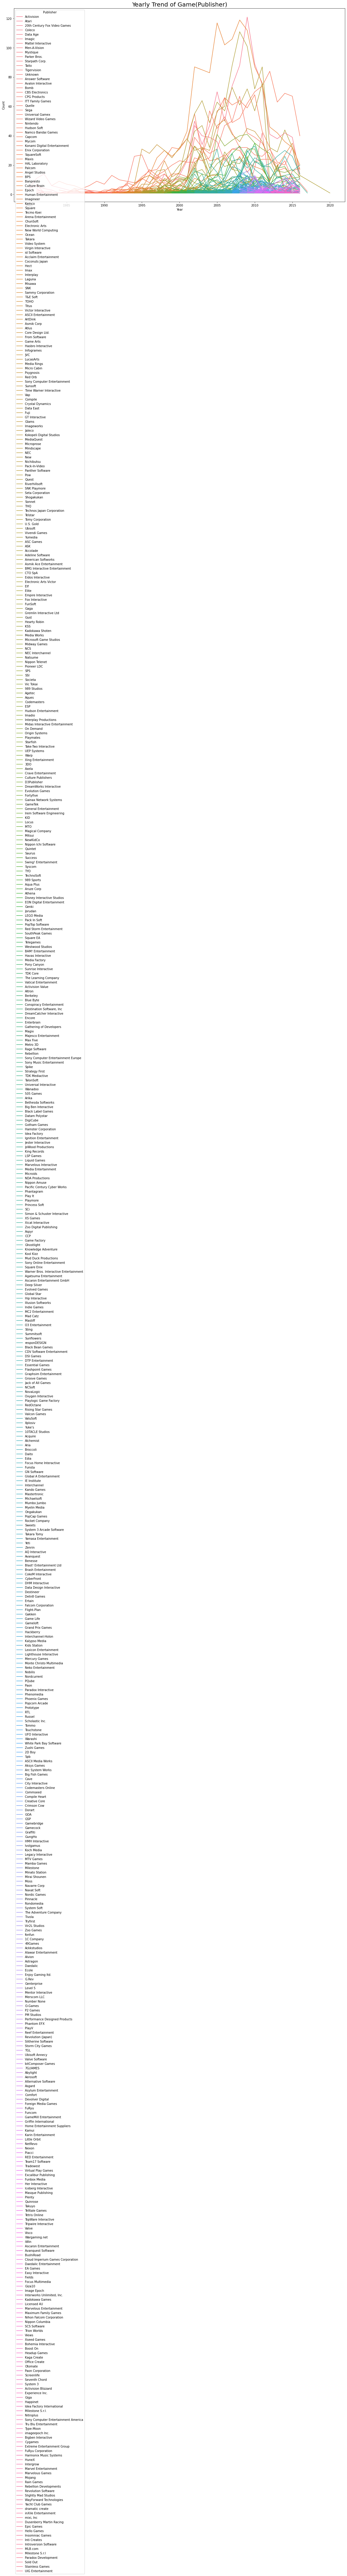

In [10]:
# 연도별 Publisher의 변화를 살펴본다
df_year_publisher = df1.groupby(['Year', 'Publisher']).size().reset_index(name='Count')

plt.figure(figsize=(20,12))
plt.title('Yearly Trend of Game(Publisher)', fontsize=20)
sns.lineplot(data=df_year_publisher, x= 'Year', y= 'Count', hue='Publisher');
plt.show();
# PS 도 시리즈가 많아서 이를 합쳐줘야 정상적으로 보이겠다.

In [11]:
# 출고량이 많은 게임 분석/시각화
df1['Total_Sales'] = df1['NA_Sales'] + df1['EU_Sales'] + df1['JP_Sales']+ df1['Other_Sales']
df1.sort_values('Total_Sales', ascending = False)
# 2006년 출시된 Nintendo 사의 'Wii Sports' (Sports) 가 82.74M 의 판매량으로 압도적 1위를 기록했다. 그렇다면 JP를 제외한 모든곳에서 1위를 차지한 Action은 어디갔는지 찾아봐야한다.
sum_sales = df1['Total_Sales'].sum()

# 글로벌 세일즈(Total_Sales) TOP 순위를 알아보자(10M 이상 팔린것 체크)
df1.sort_values('Total_Sales', ascending=False)[df1['Total_Sales'] >= 10]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
2909,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
4200,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
12580,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
3353,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
7830,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.38
1204,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26
6938,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
3015,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.01
16532,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.59,7.06,4.70,2.26,28.61
10489,Duck Hunt,NES,1984,Shooter,Nintendo,26.93,0.63,0.28,0.47,28.31


Wii 시리즈 전체 판매량: 287.17
Mario 시리즈 전체 판매량: 555.28
Pokemon 시리즈 전체 판매량: 188.09
Tetris 시리즈 전체 판매량: 53.64
GTA 시리즈 전체 판매량: 160.74
Gran Turismo 시리즈 전체 판매량: 72.22
Call of Duty 시리즈 전체 판매량: 243.54
Brain Age 시리즈 전체 판매량: 35.62 

Action 장르 전체 판매량: 1712.98 



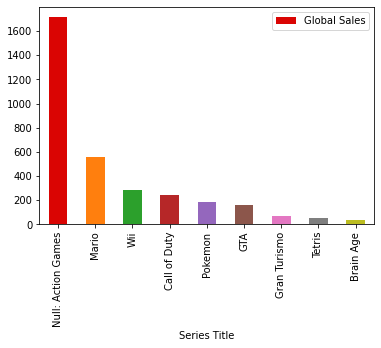

In [12]:
# 시리즈물이 많아서, 각 회사의 IP별로 구분해서 볼 필요가 있다.
# Total_Sales 10M 이상에 이름을 올린 게임 시리즈:  Wii, Mario, Pokemon, Tetris, Grand Theft Auto(GTA), Gran Turismo, Call of Duty, Brain Age
# 각각의 총 판매량을 시각화 해보자.
# Wii
sales_Wii = df1[df1.Name.str.contains('Wii')]['Total_Sales'].sum()
print('Wii 시리즈 전체 판매량:', round(sales_Wii, 2))
# Mario
sales_Mario = df1[df1.Name.str.contains('Mario')]['Total_Sales'].sum()
print('Mario 시리즈 전체 판매량:', round(sales_Mario, 2))
# Pokemon
sales_Pokemon = df1[df1.Name.str.contains('Pokemon')]['Total_Sales'].sum()
print('Pokemon 시리즈 전체 판매량:', round(sales_Pokemon, 2))
# Tetris
sales_Tetris = df1[df1.Name.str.contains('Tetris')]['Total_Sales'].sum()
print('Tetris 시리즈 전체 판매량:', round(sales_Tetris, 2))
# Grand Theft Auto
sales_GTA = df1[df1.Name.str.contains('Grand Theft Auto')]['Total_Sales'].sum()
print('GTA 시리즈 전체 판매량:', round(sales_GTA, 2))
# Gran Turismo
sales_Gran = df1[df1.Name.str.contains('Gran Turismo')]['Total_Sales'].sum()
print('Gran Turismo 시리즈 전체 판매량:', round(sales_Gran, 2))
# Call of Duty
sales_CoD = df1[df1.Name.str.contains('Call of Duty')]['Total_Sales'].sum()
print('Call of Duty 시리즈 전체 판매량:', round(sales_CoD, 2))
# Brain Age
sales_BA = df1[df1.Name.str.contains('Brain Age')]['Total_Sales'].sum()
print('Brain Age 시리즈 전체 판매량:', round(sales_BA, 2), '\n')

# Action 게임 총 판매양
sales_Action = df1[df1.Genre == 'Action']['Total_Sales'].sum()
print('Action 장르 전체 판매량:', round(sales_Action, 2), '\n')
# 시각화를 위해 새 데이터프레임을 만들었다
new_df = pd.DataFrame({
    'Series Title': ['Wii', 'Mario', 'Pokemon', 'Tetris', 'GTA', 'Gran Turismo', 'Call of Duty', 'Brain Age', 'Null: Action Games'],
    'Global Sales': [sales_Wii, sales_Mario, sales_Pokemon, sales_Tetris, sales_GTA, sales_Gran, sales_CoD, sales_BA, sales_Action] 
    })
new_df = new_df.sort_values('Global Sales', ascending=False).reset_index(drop=True)


new_df.plot.bar(x='Series Title', y='Global Sales', color=colors)
plt.show();

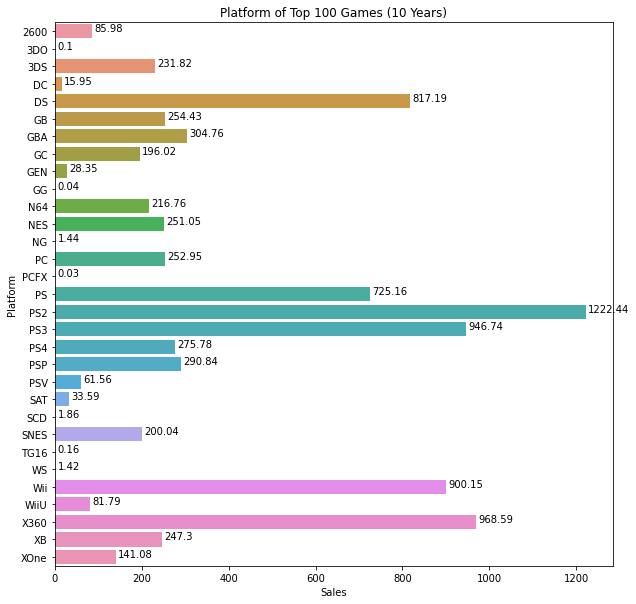

In [16]:
# 역대 가장 많은 판매량을 올린 게임은 Nintendo사의 Mario 시리즈 였다. 근데 이것도 장르가 Misc(기타)..
# 확실한 결론을 위해 Action 종류의 순위를 매겨보자..
test = df1[df1.Genre == 'Action'].sort_values('Total_Sales', ascending=False).reset_index(drop=False)
test
# sns.barplot(data = test, x= 'Name', y='Total_Sales')


# top100 Platform 그래프
top100_platform = df1.groupby(['Platform'])['Total_Sales'].sum().reset_index()
platform = top100_platform['Platform'].values
plt.figure(figsize=(10, 10))
top100_platform_sales = sns.barplot(x ='Total_Sales', y='Platform', data=top100_platform)
cnt = 0
for value in top100_platform['Total_Sales']:
    top100_platform_sales.text(x=value + 5, y=cnt, s=str(round(value,2)),
            color='black', size=10)
    cnt+=1
plt.title('Platform of Top 100 Games (10 Years)')
plt.xlabel('Sales')
plt.ylabel('Platform')
plt.show()

TypeError: ignored

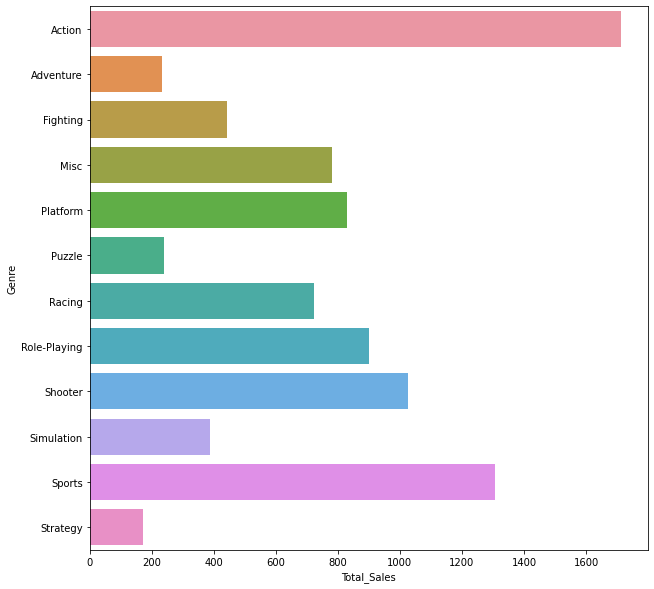

In [19]:
# top100 Genre 그래프
top100_genre = df1.groupby(['Genre'])['Total_Sales'].sum().reset_index()
platform = top100_genre['Genre'].values
plt.figure(figsize=(10, 10))
top100_genre = sns.barplot(x ='Total_Sales', y='Genre', data=top100_genre)
cnt = 0
for value in top100_genre['Total_Sales']:
    top100_genre.text(x=value + 5, y=cnt, s=str(round(value,2)),
            color='black', size=10)
    cnt+=1
plt.xlabel('Sales')
plt.ylabel('Genre')
plt.show()

TypeError: ignored

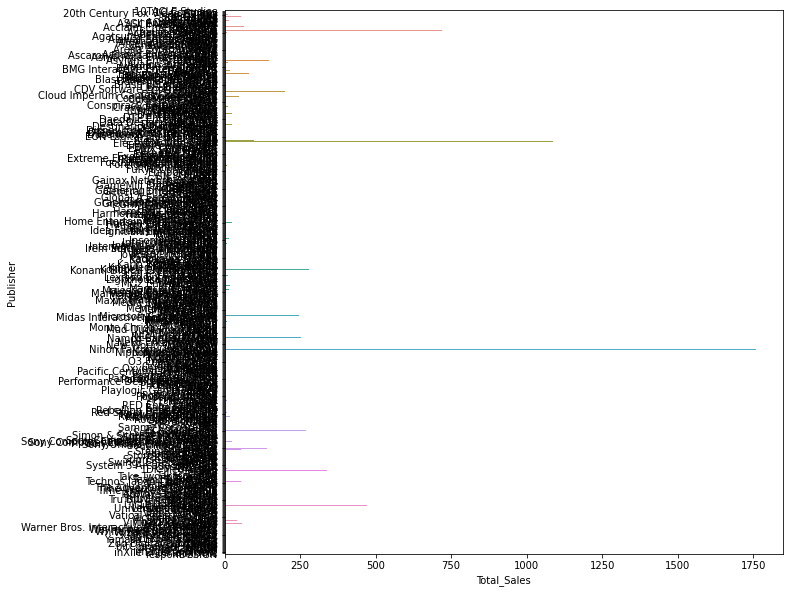

In [20]:
# top100 Publisher 그래프
top100_publisher = df1.groupby(['Publisher'])['Total_Sales'].sum().reset_index()
platform = top100_publisher['Publisher'].values
plt.figure(figsize=(10, 10))
top100_publisher = sns.barplot(x ='Total_Sales', y='Publisher', data=top100_publisher)
cnt = 0
for value in top100_publisher['Total_Sales']:
    top100_publisher.text(x=value + 5, y=cnt, s=str(round(value,2)),
            color='black', size=10)
    cnt+=1
plt.xlabel('Sales')
plt.ylabel('Publisher')
plt.show()

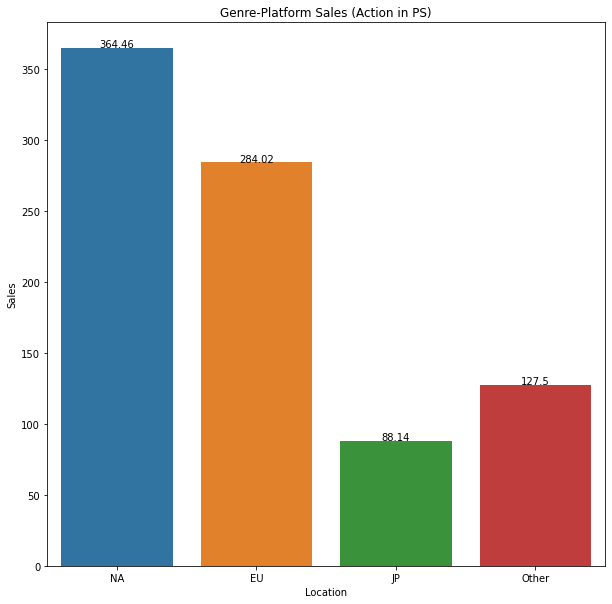

In [22]:
Platform_filter = (df1[df1.Genre=='Action'].Platform.str.contains('PS')) # 조건식 작성
df_action_ps = df1[df1.Genre=='Action'].loc[Platform_filter].reset_index(drop = True)
df_action_ps

plt.figure(figsize=(10,10))
locate_NA = df_action_ps['NA_Sales'].sum()
locate_EU = df_action_ps['EU_Sales'].sum()
locate_JP = df_action_ps['JP_Sales'].sum()
locate_Other = df_action_ps['Other_Sales'].sum()
locate_group = pd.DataFrame({'locate':['NA','EU','JP','Other'],'Sales':[locate_NA, locate_EU,locate_JP,locate_Other]})
locate_barplot = sns.barplot(x='locate', y='Sales',data=locate_group)
Sales = locate_group['Sales'].values
cnt = 0
for value in locate_group['Sales']:
    locate_barplot.text(x=cnt, y=value+0.5, s=str(str(round(value,2))),
            color='black', size=10, ha='center')
    cnt+=1
plt.title('Genre-Platform Sales (Action in PS)')
plt.xlabel('Location')
plt.ylabel('Sales')
plt.show()